In [1]:
using Revise
includet("vtol.jl")
includet("adaptation.jl")
includet("high_level_control.jl")
includet("control_allocation.jl")
includet("simulation.jl")
import .ControlAllocation: n_x, n_u, n_λ, n_W
import .HighLevelController: ref_pose, ref_velocity, RefTrajParams
import .Simulation: SimulationData, SimulationParams, dudt!, adaptive_control_allocator!
import .VTOL: VTOLParams
using LinearAlgebra, Plots, DifferentialEquations, ForwardDiff, StaticArrays, DiffEqCallbacks

In [9]:
x0 = @MVector zeros(n_x);

sim = SimulationParams()

r0 = ref_pose(sim.t0, RefTrajParams())
rdot0 = ref_velocity(sim.t0, RefTrajParams())
x0[1] = 0.0 + r0[1]  # Initial position x
x0[4] = 0.0 + rdot0[1]  # Initial velocity x
x0[2] = 1.0 + r0[2]  # Initial position y
x0[5] = 0.0 + rdot0[2]  # Initial velocity y
x0[3] = r0[3]+deg2rad(4.0)  # Initial pitch angle

xhat0 = x0

λ = @MVector zeros(n_λ);
u = @MVector[0.01, 0.01, 0.4, -0.3, x0[3]];
vtol = VTOLParams()
W_true = @SVector[vtol.CDδ, vtol.CDα, vtol.CDt, vtol.CLδ, vtol.CLα, vtol.Cmδ, vtol.Cmα, 1.0, 0.0]
W = MVector{n_W}(W_true*1.5)

cb = PeriodicCallback(adaptive_control_allocator!, sim.dt;initial_affect=true)

data = SimulationData(u=u, λ=λ, W=W, xhat=xhat0)

prob = ODEProblem(dudt!, x0, (sim.t0, sim.t_final), data)

@time sol = solve(prob, Tsit5(), callback = cb)

  0.191042 seconds (629.31 k allocations: 204.512 MiB, 17.87% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 6002-element Vector{Float64}:
  0.0
  0.0
  0.00122075947806127
  0.01
  0.01
  0.02
  0.02
  0.03
  0.03
  0.04
  ⋮
 29.96
 29.96
 29.97
 29.97
 29.98
 29.98
 29.990000000000002
 29.990000000000002
 30.0
u: 6002-element Vector{MVector{6, Float64}}:
 [-260.0111268042049, 101.00556340210242, 0.06981317007977318, 19.985219285847666, 0.009244824443644162, 0.0]
 [-260.0111268042049, 101.00556340210242, 0.06981317007977318, 19.985219285847666, 0.009244824443644162, 0.0]
 [-259.9867296107717, 101.00557276333191, 0.06981448695828826, 19.985297445606047, 0.006094369965650932, 0.002153260481800216]
 [-259.811271286291, 101.0055281893126, 0.06989905291709875, 19.98589940405218, -0.016116445640281248, 0.01689370224748194]
 [-259.811271286291, 101.0055281893126, 0.06989905291709875, 19.98589940405218, -0.016116445640281248, 0.01689370224748194]
 [-259.61141029774166, 101.00524626233542, 0.07011660525987005, 19.9863130821

In [3]:
t_vec = data.t_hist
τ = zeros(n_λ,length(t_vec))

L_vec = zeros(length(t_vec))

J_vec = zeros(length(t_vec))

k_vec = zeros(n_λ,length(t_vec))

FOO_vec = zeros(n_u+n_λ, length(t_vec))

M_aero_vec = zeros(length(t_vec))
α_vec = zeros(length(t_vec))
e_s_vec = zeros(6, length(t_vec))
norm_e_s_vec = zeros(length(t_vec))

uλWdot_vec = zeros(n_u+n_λ+n_W, length(t_vec)-1)

Lift_vec = zeros(length(t_vec))

lyapunov_vec = zeros(length(t_vec))
Vdot_vec = zeros(length(t_vec))
# Γ_ϵ = Diagonal([10.0, 10.0, 10.0, 10.0, 100.0, 100.0])

sliding_vec = zeros(n_λ, length(t_vec))
du = zeros(length(sol(0)))

u_hist = zeros(n_u, length(t_vec))
λ_hist = zeros(n_λ, length(t_vec))
W_hist = zeros(n_W, length(t_vec))


norm_W_vec = zeros(length(t_vec))

vel_mag_vec = zeros(length(t_vec))

d2Ldxdudλ_vel_vec = zeros(length(t_vec))

for (j, t) in enumerate(t_vec)
    x = sol(t)
    u = data.u_hist[j]
    λ = data.λ_hist[j]
    W = data.W_hist[j]
    xhat = data.xhat_hist[j]
    u_hist[:,j] = u[1:end]
    λ_hist[:,j] = λ[1:end]
    W_hist[:,j] = W[1:end]
    norm_W_vec[j] = norm(W)
    vel_mag_vec[j] = sqrt(x[4]^2 + x[5]^2)
    # W_reshape = reshape(W, 5, n_λ)
    # NN = W_reshape' * [Φ_Nn_W(x,u, u[5],model);1.0] ./scale
    # NN_hist[:,j] = NN
    # V = sqrt(x[4]^2 + x[5]^2)
    # NN_truth_hist[:,j] = Φ_sim(V, α(x,x[3]), x[6], u[1:4], α(x,u[5]))
    # ϕ = Φ_full(t,x, u, W_true)
    e_s_vec[:,j] = x - xhat
    norm_e_s_vec[j] = norm(e_s_vec[:,j])
    # τ[:,j] = ϕ
    # L_vec[j] = L_flat(vcat(sol(t), t), n_x, n_u, n_λ, n_W)
    # J_vec[j] = J(t, x, u)
    # k_vec[:,j] = k(t,x, u,z,xhat)-[u[6];u[7];0]
    # FOO_vec[:,j] = [dL_du(t, x, u, λ, W, z, xhat); constraint(t, x, u, λ, W, z, xhat)]
    # α_vec[j] = α(x, x[3])
    # if j < length(t_vec) 
    #     uλWdot_vec[:,j] = uλW_dot(t, x, u, λ, W, z, xhat,data)
    # end

    # dLduλ = [dL_du(t,x,u,λ,W,z,xhat); constraint(t,x,u,λ,W,z,xhat)]
    # d2Ldu = dL_du_jacobian(t, x, u, λ, W, z, xhat)
    # d2Ldλ = dL_dλ_jacobian(t, x, u, λ, W, z, xhat)

    # d2Ldxdudλ = [d2Ldu[:,SA[1:n_x...]]; d2Ldλ[:,SA[1:n_x...]]]

    # d2Ldxdudλ_vel_vec[j] = norm(d2Ldxdudλ[:,SA[4:6...]])
    # # M_aero_vec[j] = M_aero_true(x, u, α_vec[j])
    # dudt!(du,sol(t),result,t)
    # actuator_rate_vec[:,j] = du[n_x+1:n_x+n_u]
    # Lift_vec[j] = F_aero(x, u, α_vec[j])[2]
    # s = sliding_surface(t, x, u[5],z)
    # sliding_vec[:,j] = s
    # lyapunov_vec[j] = 0.5*FOO_vec[:,j]'*FOO_vec[:,j] + 0.5*(W - vec(W_NN_0))'/Γ_W_inv*(W - vec(W_NN_0)) + 0.5*s'*M*s
    # Vdot_vec[j] = -s'*K*s - s'*FOO_vec[n_u+1:end,j] - FOO_vec[:,j]'*10*FOO_vec[:,j]
end



┌ Info: Saved animation to /home/dmrc/git/adaptive-control-underactuated/vtol_animation.gif
└ @ Plots /home/dmrc/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/home/dmrc/git/adaptive-control-underactuated/vtol_animation.gif")
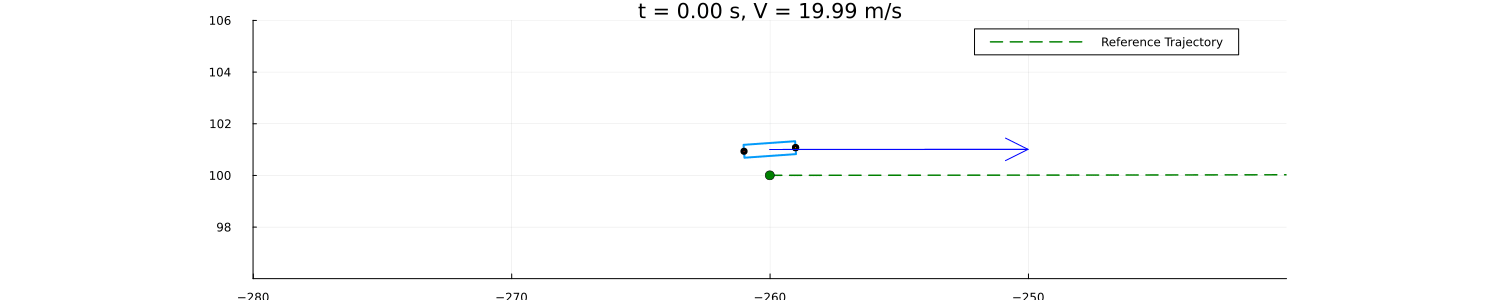

In [11]:
include("animation.jl")
animate_vtol(sol, t-> ref_pose(t, RefTrajParams()); fps=15)

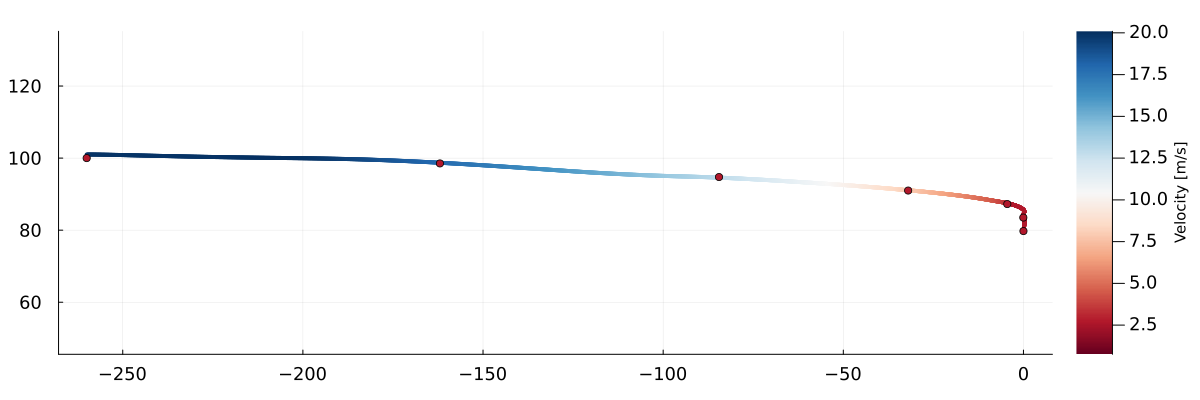

In [4]:
gr()
x_pos_vec = [sol(t)[1] for t in t_vec]
z_pos_vec = [sol(t)[2] for t in t_vec]
plot(x_pos_vec, z_pos_vec,# xlabel=L"$p_x$ [m]", ylabel=L"$p_z$ [m]",
    #  title="VTOL Trajectory", label="Trajectory",
      legend=false, line_z = vel_mag_vec, colormap=:RdBu, linewidth=4, colorbar=:bottom, colorbar_title="Velocity [m/s]")
rx_vec = [ref_pose(t, RefTrajParams())[1] for t in t_vec]
ry_vec = [ref_pose(t, RefTrajParams())[2] for t in t_vec]
# plot!(rx_vec, ry_vec, label="Reference Trajectory", color=:black, linestyle=:dash, linewidth=4)
pitches = []
for t_plot in sim.t0:5.0:sim.t_final
    x_ref = ref_pose(t_plot, RefTrajParams())
    scatter!([x_ref[1]], [x_ref[2]], color=:red, label="")
    push!(pitches, sol(t_plot)[3])
end
plot!(aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, size=(1200,400))

# Plots.savefig("paper/trajectory_tracking.svg")
# pitches*rad2deg(1)

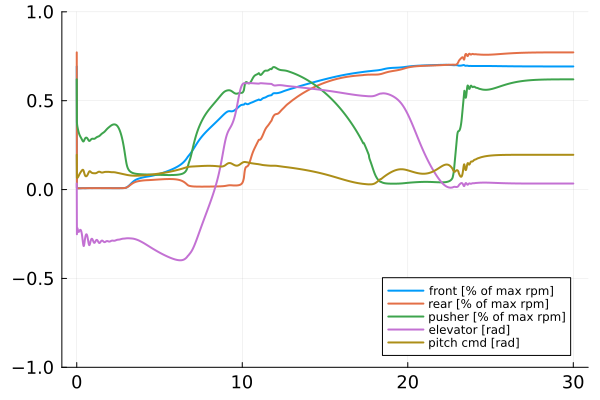

In [5]:
gr()
# plotlyjs()
# colors = [colorant"#a559aa", colorant"#59a89c", colorant"#f0c571", colorant"#e02b35", colorant"#082a54"]
# colors = palette[3:end-2]
plot(t_vec, u_hist',label=["front [% of max rpm]" "rear [% of max rpm]" "pusher [% of max rpm]" "elevator [rad]" "pitch cmd [rad]"],
     # xlabel="Time [s]", ylabel="Control Inputs",
      # title="Control Allocation",
       ylims = (-1.0,1.0),linewidth = 2,legend=true, xtickfontsize=12, ytickfontsize=12)#, color=colors[1:4]')
# plot!(sol, idxs=(0, 3), #xlabel="Time [s]", ylabel="Control Inputs",#legend =true, label = "pitch [rad]",
      # title="Control Allocation",
      #  ylims = (-1.0,1.0),linewidth = 4)
      # pitch_color = :blue#palette[end-1]
# plot!(twinx(), t_vec, rad2deg(1)*u_hist[5,:], linewidth=2, color = pitch_color,legend=false, size = (600,300), xtickfontsize=14, ytickfontsize=14,  y_foreground_color_text=pitch_color)
# Plots.savefig("paper/vtol_control_inputs.svg")

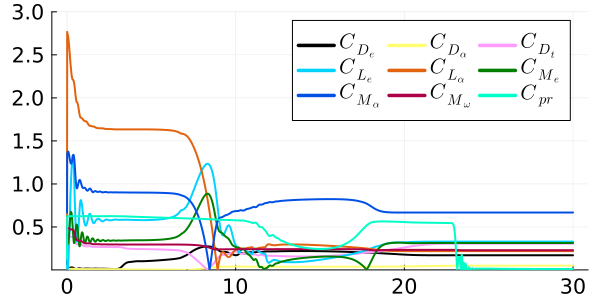

In [6]:
using LaTeXStrings
gr()
rear_prop_degrade = [VTOL.rear_prop_degradation(sol(t), u_hist[:,i])/u_hist[3,i]^2 for (i,t) in enumerate(t_vec)]
labels = [L"C_{D_e}", L"C_{D_\alpha}", L"C_{D_t}", L"C_{L_e}", L"C_{L_\alpha}", L"C_{M_e}", L"C_{M_\alpha}", L"C_{M_\omega}", L"C_{pr}"]
palette = distinguishable_colors(length(labels))
plot()
for i in 1:n_W-1
    plot!(t_vec, abs.(W_hist[i,:] .- W_true[i]), label=labels[i], linewidth=2, color=palette[i])
end
plot!(t_vec, abs.(W_hist[end,:] - rear_prop_degrade), label=labels[end], linewidth=2, color=palette[end])
plot!(legend=true, legend_columns=3,ylims=(0.001, 3), xtickfontsize=14, ytickfontsize=14, legendfontsize=14, size=(600,300))
